In [313]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')





### Prepare the Data

In [314]:
df = pd.read_csv('Data/HousingPrices_Dataset.csv')

# Delete all the columns with more than 80 % NaN values
perc =df.isnull().sum()/len(df)*100
todelete = perc[perc >80].keys()
df.drop(columns=todelete)

# Create a dataframe with all the columns with numeric data. Substract that columns from df, so df become a categorical dataframe
numcol =df._get_numeric_data().columns
dfnum = df[numcol]
df.drop(columns=numcol, inplace=True)

# Using simpleimputer to add the "mean" value in numeric dataframe, and "Missing" in categorical dataframe
imputernum = SimpleImputer(missing_values= np.nan, strategy= "mean")
imputercat = SimpleImputer(missing_values= np.nan, strategy= 'constant', fill_value='Missing')
df_num_imp= imputernum.fit_transform(dfnum)
df_cat_imp= imputercat.fit_transform(df)
df_cat_imp #this is an array
df_cat = pd.DataFrame(df_cat_imp, columns= df.columns)
df_num = pd.DataFrame(df_num_imp,columns= dfnum.columns)

In [315]:
# Check if df_num has negative values
df_num['SalePrice'].describe() 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Let's check the SalesPrice column distribution

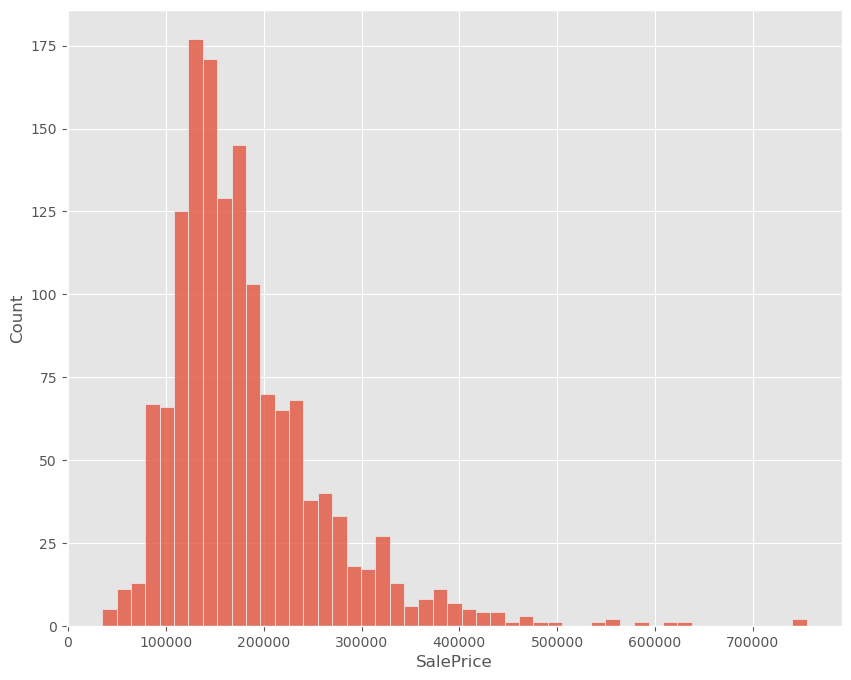

In [316]:

plt.figure(figsize=(10,8))
sns.histplot(df_num['SalePrice'])
plt.show()

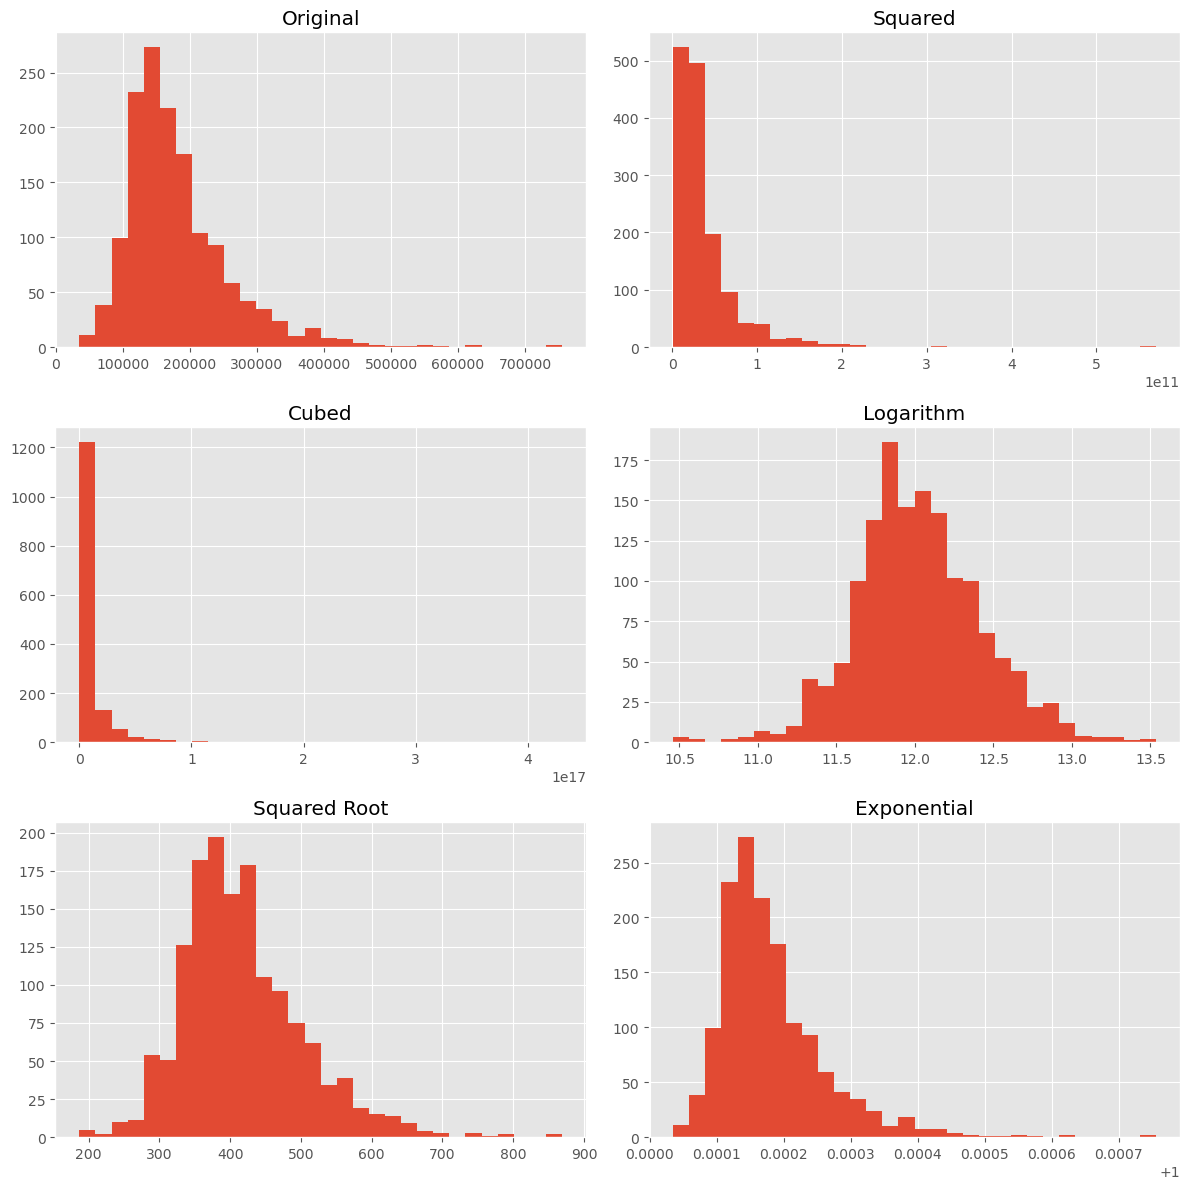

In [317]:
SalePrice_values= dfnum['SalePrice']
fig, axs = plt.subplots(3,2, figsize=(12,12))

axs[0,0].hist(SalePrice_values, bins= 30)
axs[0,0].set_title('Original')
axs[0,1].hist(SalePrice_values**2, bins= 30)
axs[0,1].set_title('Squared')
axs[1,0].hist(SalePrice_values**3, bins= 30)
axs[1,0].set_title('Cubed')
axs[1,1].hist(np.log(SalePrice_values), bins= 30)
axs[1,1].set_title('Logarithm')
axs[2,0].hist(np.sqrt(SalePrice_values), bins= 30)
axs[2,0].set_title('Squared Root')
axs[2,1].hist(np.exp(SalePrice_values/1000000000), bins= 30)
axs[2,1].set_title('Exponential')

plt.tight_layout()
plt.show()


In [318]:
### We can see that the logarithmic transformation is the most similar to a normal distribution

In [319]:
# Transform out column to a logarithmic
df_num['SalePrice'] = np.log(df_num['SalePrice'])
# Check the shape
df_num.shape

(1460, 38)

### Create a Heatmap

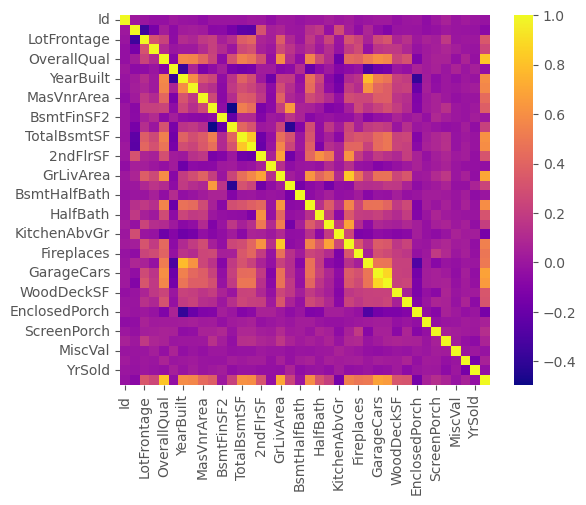

In [320]:
correlation =df_num.corr()
sns.heatmap(correlation, square=True, cmap='plasma')
plt.show()

In [321]:
### Too much independent variable. Lets create a Heatmap for the top 10 variables with strongest correlation with SalesPrice

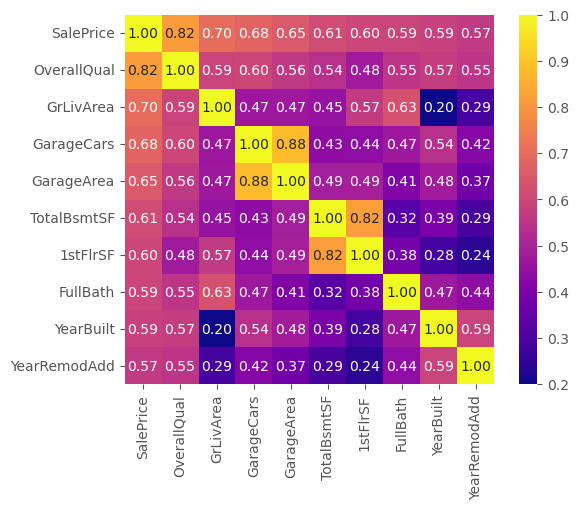

In [322]:
#manera para selecionar los mas correlacionados
topnumber= 10
cols= correlation.nlargest(topnumber, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_num[cols].values.T)
hm =sns.heatmap(cm, cbar=True, annot=True,square=True, fmt='.2f', annot_kws={'size': 10},
                yticklabels=cols.values, xticklabels=cols.values, cmap='plasma')
plt.show()

### Some multicollinearity is present. Let's create a single column with the mean of TotalBsmtSF, 1stFlrSF and GarageArea

In [323]:
df_num['Bsm1FlrGarAreaSF'] = (df_num['TotalBsmtSF'] + df_num['1stFlrSF'] +df_num['GarageArea'])/3
df_num.drop(columns=['TotalBsmtSF', '1stFlrSF','GarageArea'], inplace=True)

In [324]:
top10correlatedcolumns = ['SalePrice','OverallQual','GrLivArea','Bsm1FlrGarAreaSF','GarageCars',
 'FullBath','YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd','GarageYrBlt']

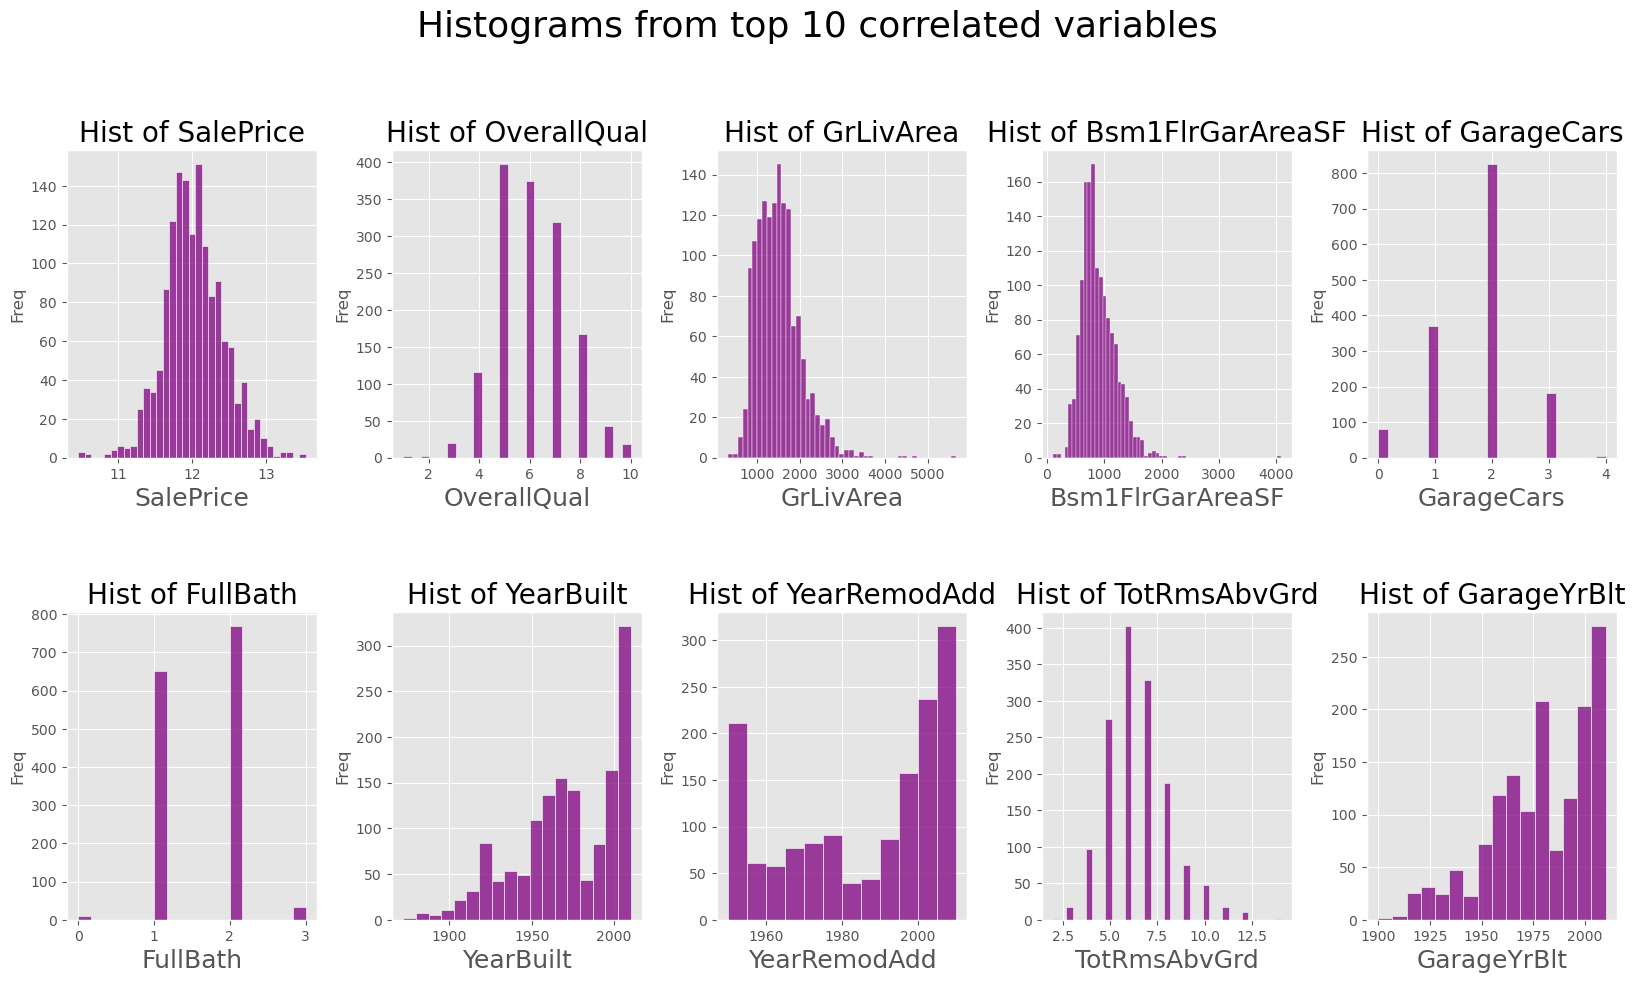

In [325]:
fig, axi = plt.subplots(2,5, figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for i, cols in enumerate(top10correlatedcolumns):
    row =i // 5
    col = i % 5
    
    sns.histplot(df_num[cols], ax= axi[row,col],color='purple')
    axi[row,col].set_title(f'Hist of {cols}', fontsize=20)
    axi[row,col].set_xlabel(cols, fontsize=18)
    axi[row,col].set_ylabel('Freq')
plt.suptitle('Histograms from top 10 correlated variables',fontsize=26, y=1.02)
plt.show()

### Boxplot of TotRmsAbvGrd to see if we can group them in small groups

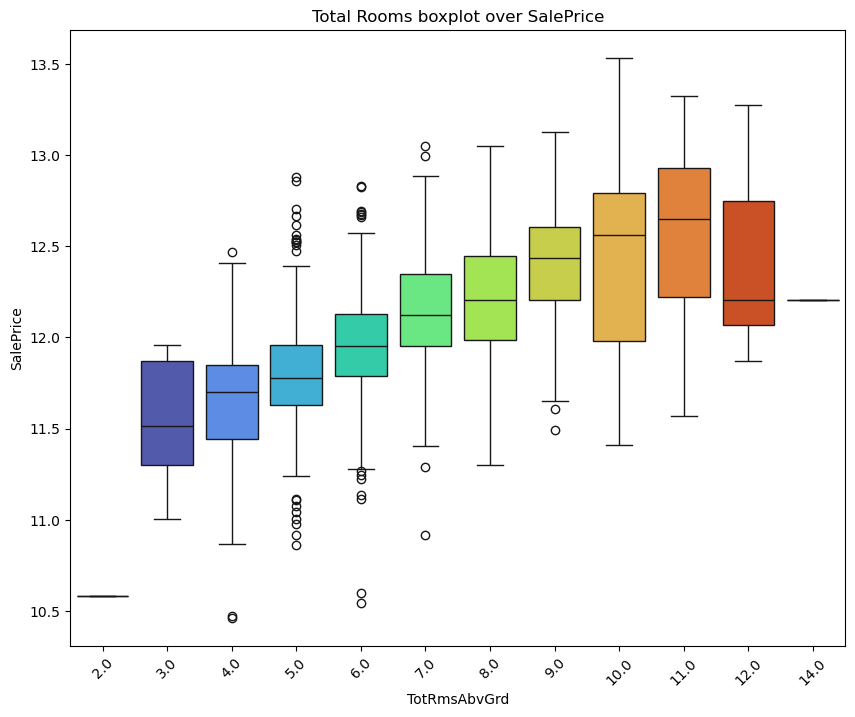

In [326]:
plt.figure(figsize=(10,8))
plt.style.use('default')
sns.boxplot(x='TotRmsAbvGrd', y= 'SalePrice', data= df_num, hue='TotRmsAbvGrd', palette='turbo', legend=False)
plt.xlabel('TotRmsAbvGrd')
plt.ylabel('SalePrice')
plt.title('Total Rooms boxplot over SalePrice')
plt.xticks(rotation=45)
plt.show()

In [327]:
maproms ={2:1,3:2,4:2,5:3,6:3,7:4,8:4,9:4,10:4,11:4,12:4,14:4}
df_num['TotRmsAbvGrdGrouped'] = df_num['TotRmsAbvGrd'].map(maproms)
df_num.drop(columns='TotRmsAbvGrd', axis=1, inplace=True)

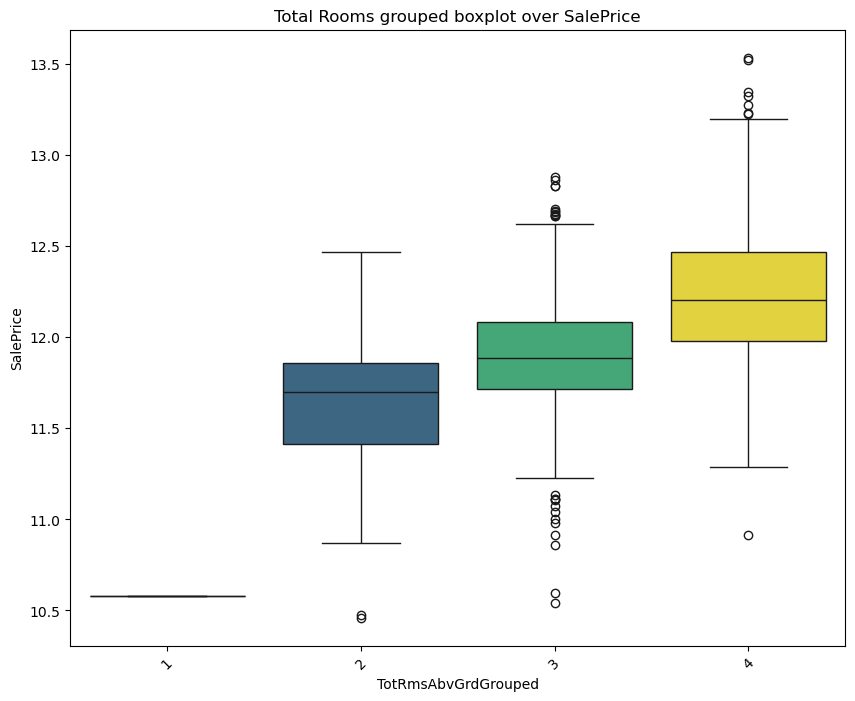

In [328]:
plt.figure(figsize=(10,8))
plt.style.use('default')
sns.boxplot(x='TotRmsAbvGrdGrouped', y= 'SalePrice', data= df_num, hue='TotRmsAbvGrdGrouped', palette='viridis', legend=False)
plt.xlabel('TotRmsAbvGrdGrouped')
plt.ylabel('SalePrice')
plt.title('Total Rooms grouped boxplot over SalePrice')
plt.xticks(rotation=45)
plt.show()

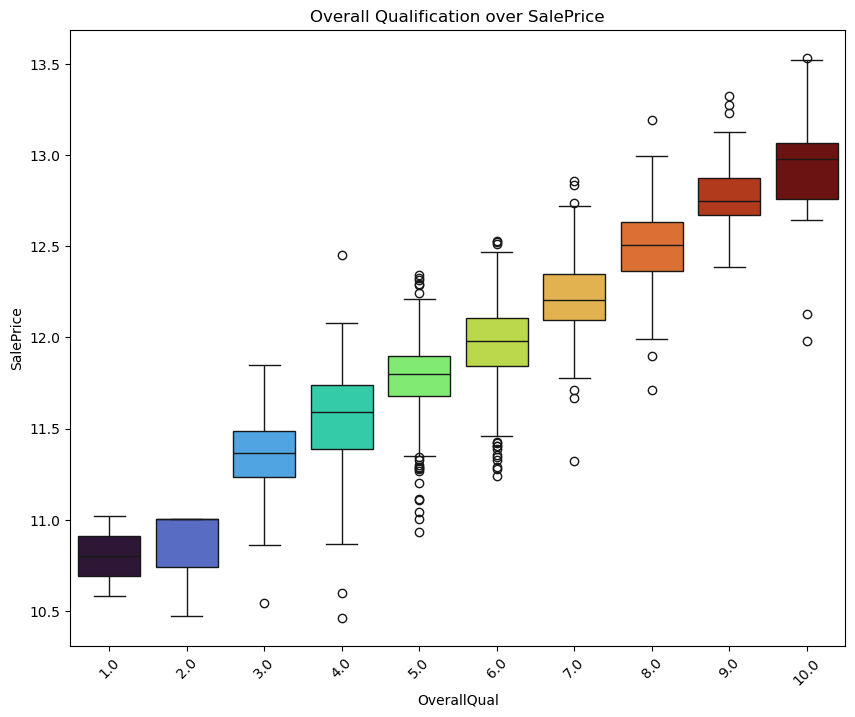

In [329]:
plt.figure(figsize=(10,8))
#plt.style.use('default')
sns.boxplot(x='OverallQual', y= 'SalePrice', data= df_num, hue='OverallQual', palette='turbo', legend=False)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('Overall Qualification over SalePrice')
plt.xticks(rotation=45)
plt.show()

In [330]:
mapover ={1:1,2:1,3:2,4:2,5:3,6:3,7:4,8:4,9:5,10:5}
df_num['OverallQualGrouped'] = df_num['OverallQual'].map(mapover)
df_num.drop(columns='OverallQual', axis=1, inplace=True)

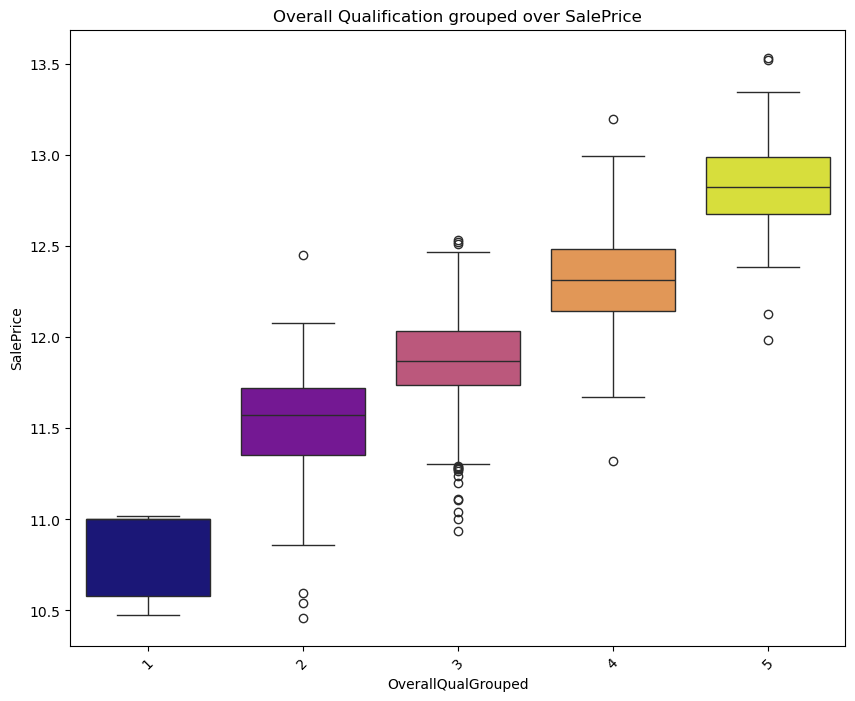

In [331]:
plt.figure(figsize=(10,8))
sns.boxplot(x='OverallQualGrouped', y= 'SalePrice', data= df_num, hue='OverallQualGrouped', palette='plasma', legend=False)
plt.xlabel('OverallQualGrouped')
plt.ylabel('SalePrice')
plt.title('Overall Qualification grouped over SalePrice')
plt.xticks(rotation=45)
plt.show()

### To detect and delete some outliers just in a quick view we do a scatter plot for the new top 10 variables 

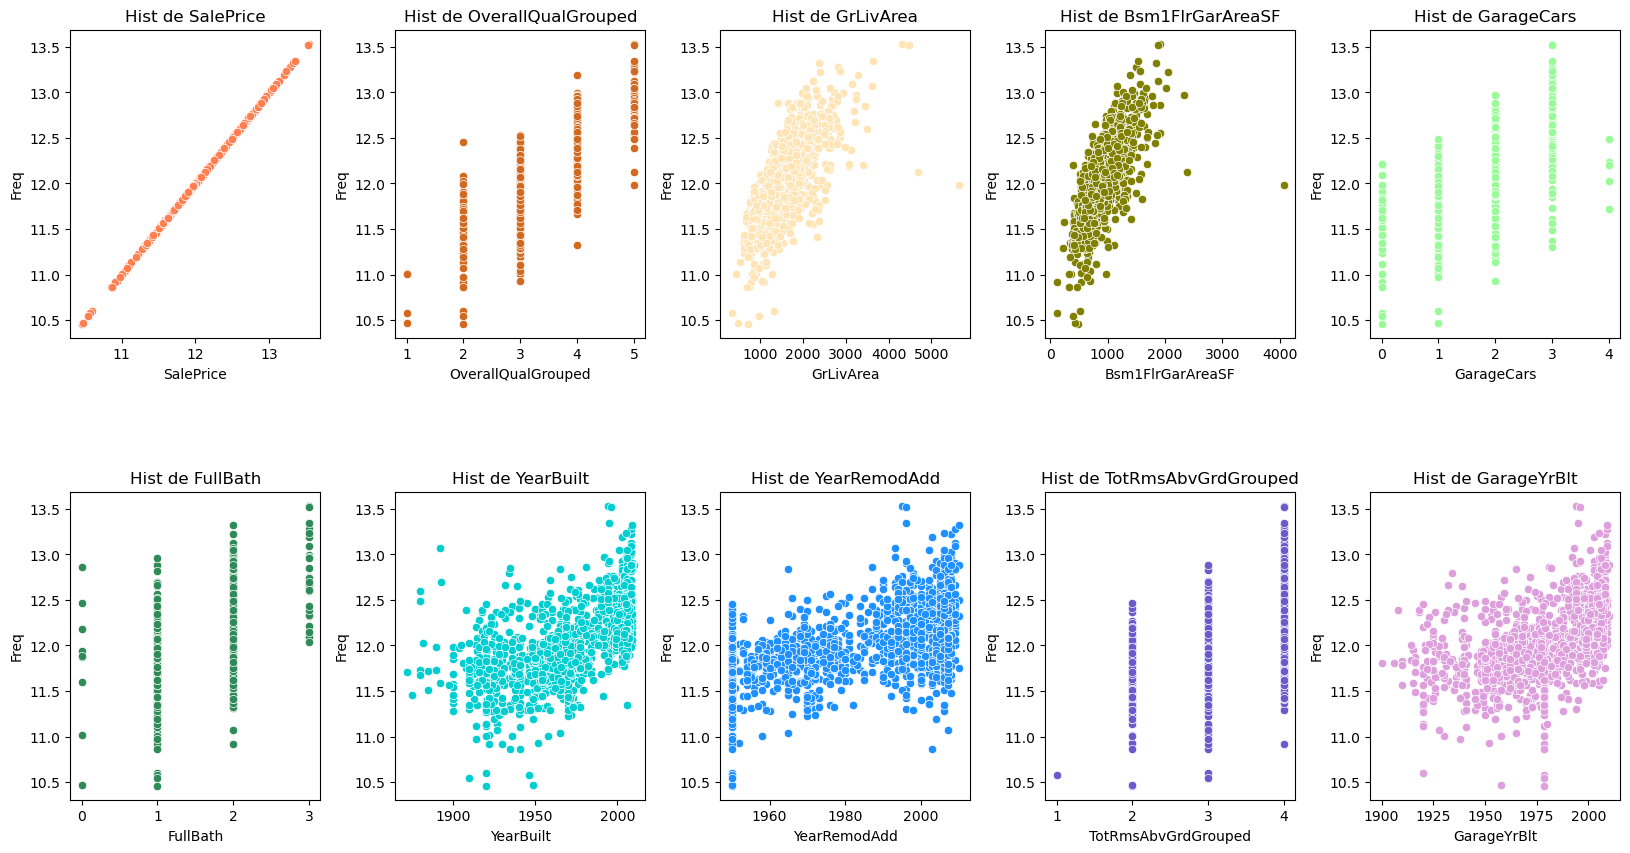

In [332]:
fig, axi = plt.subplots(2,5, figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
top10correlatedcolumnsgrouped = ['SalePrice','OverallQualGrouped','GrLivArea','Bsm1FlrGarAreaSF','GarageCars',
 'FullBath','YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrdGrouped','GarageYrBlt']
color = {0:'coral', 1:'chocolate',2:'moccasin', 3:'olive', 4:'palegreen', 5: 'seagreen', 6: 'darkturquoise', 
         7:'dodgerblue', 8:'slateblue', 9: 'plum'}
for i, column in enumerate(top10correlatedcolumnsgrouped):
    row =i // 5
    col = i % 5
    
    sns.scatterplot(x=column,y='SalePrice',data=df_num, ax= axi[row,col], color=color[i])
    axi[row,col].set_title(f'Hist de {column}')
    axi[row,col].set_xlabel(column)
    axi[row,col].set_ylabel('Freq')
plt.show()

In [333]:
# Deleting some outliers

df_num.drop(index=df_num['GrLivArea'].nlargest(2).index, inplace=True)
df_num.drop(index=df_num['Bsm1FlrGarAreaSF'].nlargest(1).index, inplace=True)

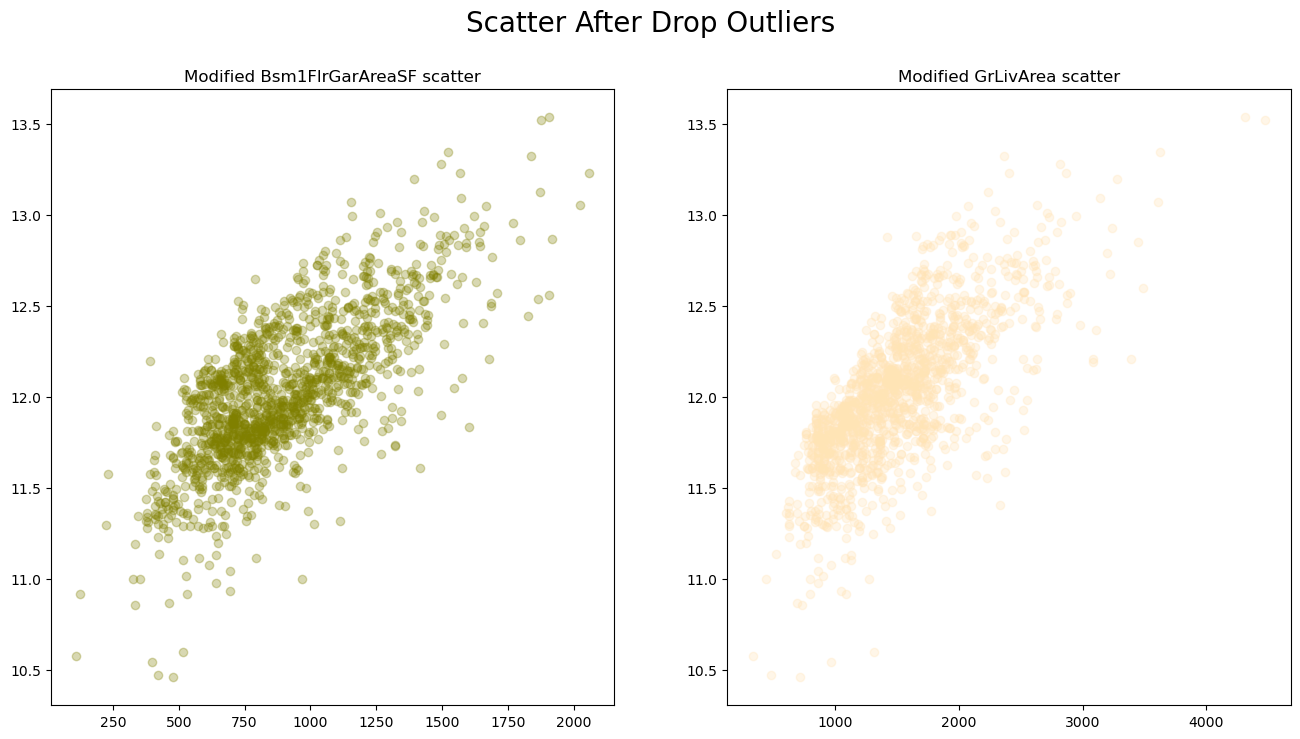

In [334]:
fig , ax = plt.subplots(1,2, figsize=(16,8))
ax[0].scatter('Bsm1FlrGarAreaSF', 'SalePrice',data=df_num, color='olive', alpha=0.3)
ax[0].set_title('Modified Bsm1FlrGarAreaSF scatter')

ax[1].scatter('GrLivArea', 'SalePrice',data=df_num, color='moccasin', alpha=0.3)
ax[1].set_title('Modified GrLivArea scatter')
plt.suptitle('Scatter After Drop Outliers', fontsize=20)
plt.show()

### To check the skew in our top10correlatedcolumns we should use this:

In [335]:
for columna in top10correlatedcolumnsgrouped:
    print(columna,'tiene una asimetria de ', df_num[columna].skew())

SalePrice tiene una asimetria de  0.11792374211893303
OverallQualGrouped tiene una asimetria de  0.0855552207723679
GrLivArea tiene una asimetria de  1.002780824698037
Bsm1FlrGarAreaSF tiene una asimetria de  0.7289610848655882
GarageCars tiene una asimetria de  -0.34167018013484174
FullBath tiene una asimetria de  0.024549602040748637
YearBuilt tiene una asimetria de  -0.6111891393072905
YearRemodAdd tiene una asimetria de  -0.5009743062730364
TotRmsAbvGrdGrouped tiene una asimetria de  -0.5145187877526564
GarageYrBlt tiene una asimetria de  -0.6661304444153938


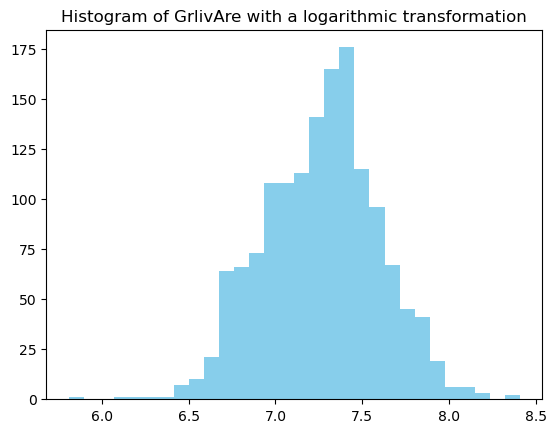

asimetria de GrLivArealog -0.07748339100245605  is reduced from the previous one


In [336]:
# As our target variable is logarithmic, we must change this variable to logarithmic too.
df_num['GrLivArealog'] = np.log(df_num['GrLivArea'])
plt.hist(df_num['GrLivArealog'],bins=30, color='skyblue')
plt.title('Histogram of GrlivAre with a logarithmic transformation')
plt.show()
print('asimetria de GrLivArealog', df_num['GrLivArealog'].skew(), ' is reduced from the previous one')

In [337]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

In [338]:
df_num.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'Bsm1FlrGarAreaSF',
       'TotRmsAbvGrdGrouped', 'OverallQualGrouped', 'GrLivArealog'],
      dtype='object')

In [339]:
x = df_num[['GrLivArealog']]
y= df_num['SalePrice']
x.shape

(1457, 1)

### Let's try to build a Linear Regression model

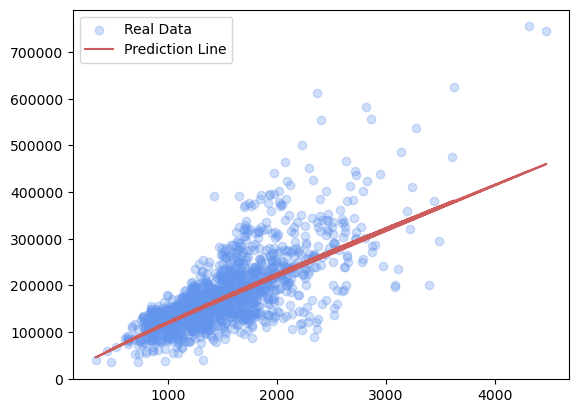

R2 after normalize y and yhat as them were in logarithmic transfomation  0.5210041754057758
MSE after normalize y and yhat as them were in logarithmic transfomation  3006588669.829302


In [340]:
model= linear_model.LinearRegression()
model.fit(x,y)
ypre= model.predict(x)

plt.scatter(np.exp(x),np.exp(y),color='cornflowerblue',label='Real Data', alpha=0.3)
plt.plot(np.exp(x), np.exp(ypre), color='indianred', label='Prediction Line')
plt.legend()
plt.show()
print('R2 after normalize y and yhat as them were in logarithmic transfomation ', r2_score(np.exp(y),np.exp(ypre)))
print('MSE after normalize y and yhat as them were in logarithmic transfomation ' , mean_squared_error(np.exp(y),np.exp(ypre)))

### Changing some number columns to categorical as they are not valuable as numeric.
##### As we grouped before, we change to 5 maximum qualification, and other distribution of number of rooms
##### Also we change Number of garages and baths
##### This will help us to get dummies for those variables

In [341]:
# change OverallQualGrouped
mapover ={1:'Qual 1',2:'Qual 1',3:'Qual 2',4:'Qual 2',5:'Qual 3',6:'Qual 3',7:'Qual 4',8:'Qual 4',9:'Qual 5',10:'Qual 5'}
df_num['OverallQualGrouped']=df_num['OverallQualGrouped'].map(mapover)

# change TotRmsAbvGrdGrouped
maproms ={2:'2 Romms',3:'3-4 Rooms',4:'3-4 Rooms',5:'5-6 Rooms',6:'5-6 Rooms',7:'7-9 Rooms',8:'7-9 Rooms',9:'7-9 Rooms',
          10:'10-14 Rooms',11:'10-14 Rooms',12:'10-14 Rooms',14:'10-14 Rooms'}
df_num['TotRmsAbvGrdGrouped']=df_num['TotRmsAbvGrdGrouped'].map(maproms)

# change FullBath and GarageCars
mapcars ={ 0 : "No Garage", 1: '1Place', 2:'2Places', 3:'3Places', 4: '4Places'}
mapbath = { 0 : "No FullBath", 1: '1Baths', 2:'2Baths', 3:'3Baths'}
df_num['FullBath'], df_num['GarageCars'] = df_num['FullBath'].map(mapbath), df_num['GarageCars'].map(mapcars) 

print(df_num['OverallQualGrouped'].unique())
print(df_num['TotRmsAbvGrdGrouped'].unique())
print(df_num['FullBath'].unique())
print(df_num['GarageCars'].unique())

['Qual 2' 'Qual 3' 'Qual 1']
['3-4 Rooms' '2 Romms' nan]
['2Baths' '1Baths' '3Baths' 'No FullBath']
['2Places' '3Places' '1Place' 'No Garage' '4Places']


In [342]:
df_num.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'Bsm1FlrGarAreaSF',
       'TotRmsAbvGrdGrouped', 'OverallQualGrouped', 'GrLivArealog'],
      dtype='object')

In [343]:
# Deleting the Id column
X = df_num.drop(columns='Id')
y = df_num['SalePrice']

# Creating dummies for cattegorical variables
df_with_dummies = pd.get_dummies(X, drop_first=True, dtype=int)

from sklearn.preprocessing import StandardScaler
# Apply StandarScaler to our data
scaler_model = StandardScaler()
rsults = scaler_model.fit_transform(df_with_dummies)
df_standared = pd.DataFrame(rsults, columns= df_with_dummies.columns)

# Create the regression model
reg_model = LinearRegression()
reg_model.fit(df_standared, y)
yhat =reg_model.predict(df_standared)

# Calculate R2 and mse from the predictions
rmse_log = np.sqrt(root_mean_squared_error(np.exp(yhat), np.exp(y) ))
r2_log = r2_score(np.exp(yhat), np.exp(y))

print('root mean squared error', rmse_log)
print('r2', r2_log)

root mean squared error 2.3704826069563392e-05
r2 1.0


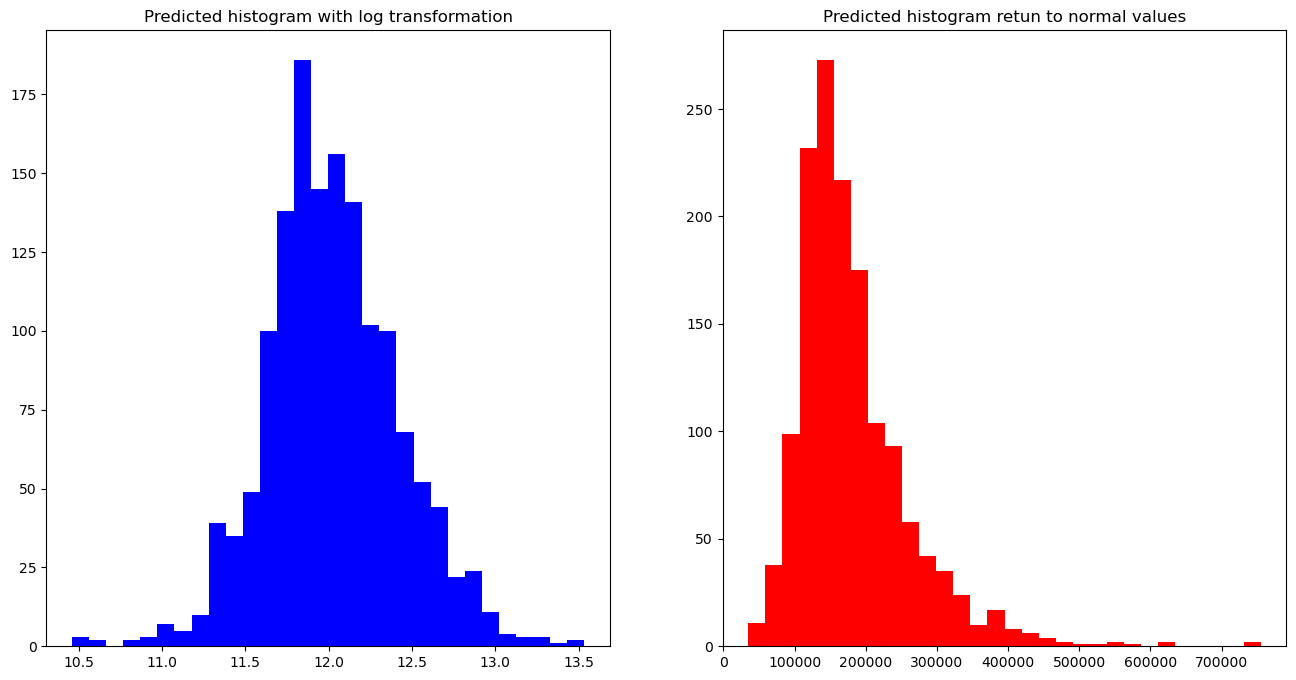

In [344]:
# Checking the predicted distribution
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].hist(yhat,bins=30, color='blue')
ax[0].set_title('Predicted histogram with log transformation')
ax[1].hist(np.exp(yhat),bins=30, color= 'red')
ax[1].set_title('Predicted histogram retun to normal values')
plt.show()

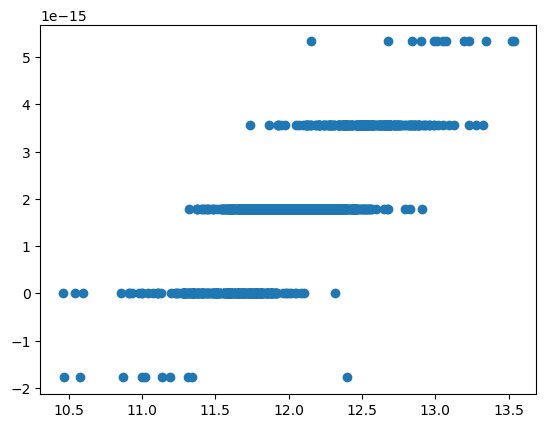

In [345]:
# Checking residuals
residuals = y- yhat
plt.scatter(yhat , residuals)
plt.show()

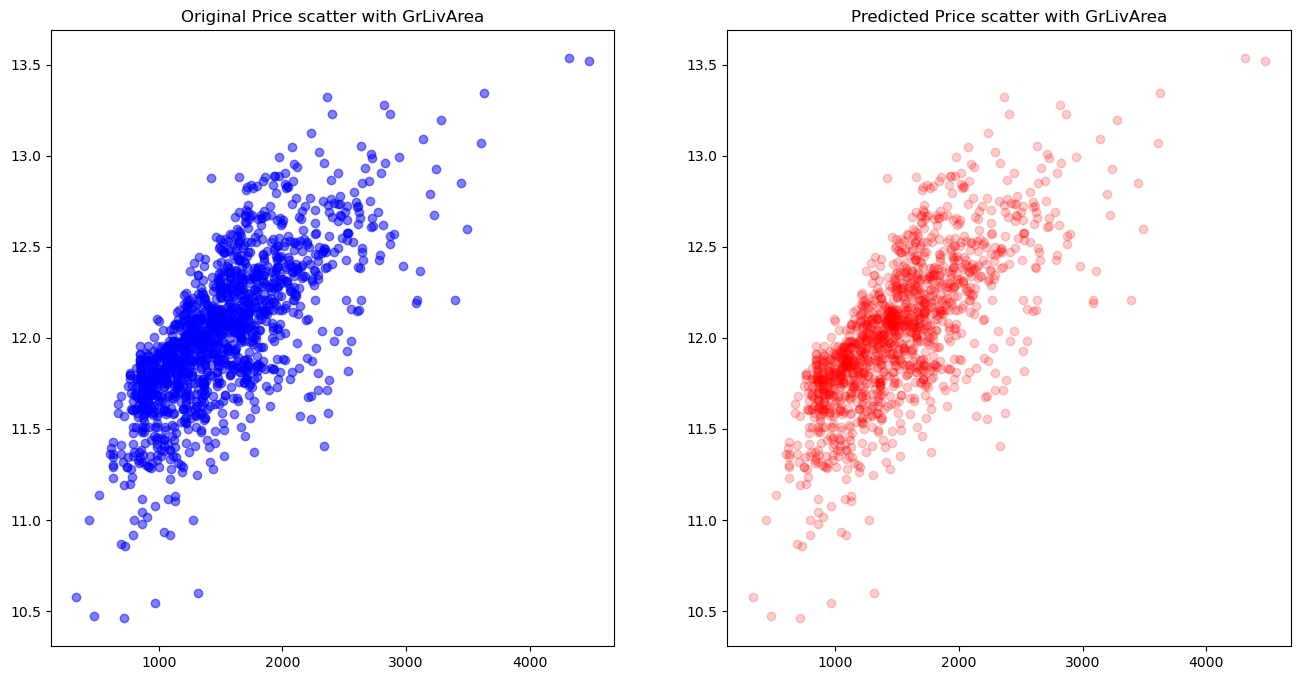

In [346]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].scatter(df_num['GrLivArea'] ,y ,color='blue', alpha=0.5)
ax[0].set_title('Original Price scatter with GrLivArea')
ax[1].scatter(df_num['GrLivArea'] ,yhat ,color='red', alpha=0.2)
ax[1].set_title('Predicted Price scatter with GrLivArea')
#ax[1].plot(yhat,y, color='red', linestyle='--')
plt.show()

#### Look like StandarScaler works fine, lets check other Scalers

In [347]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer

In [348]:
mmmodel= MinMaxScaler()
Rmodel =RobustScaler()
nmodel= Normalizer()

root mean squared error with MinMaxScaler()  : 2.913978852802109e-10
r2 with MinMaxScaler()  : 1.0
root mean squared error with RobustScaler()  : 2.301384238225473e-09
r2 with RobustScaler()  : 1.0
root mean squared error with Normalizer()  : 24504.720854381318
r2 with Normalizer()  : 0.8833253112518298


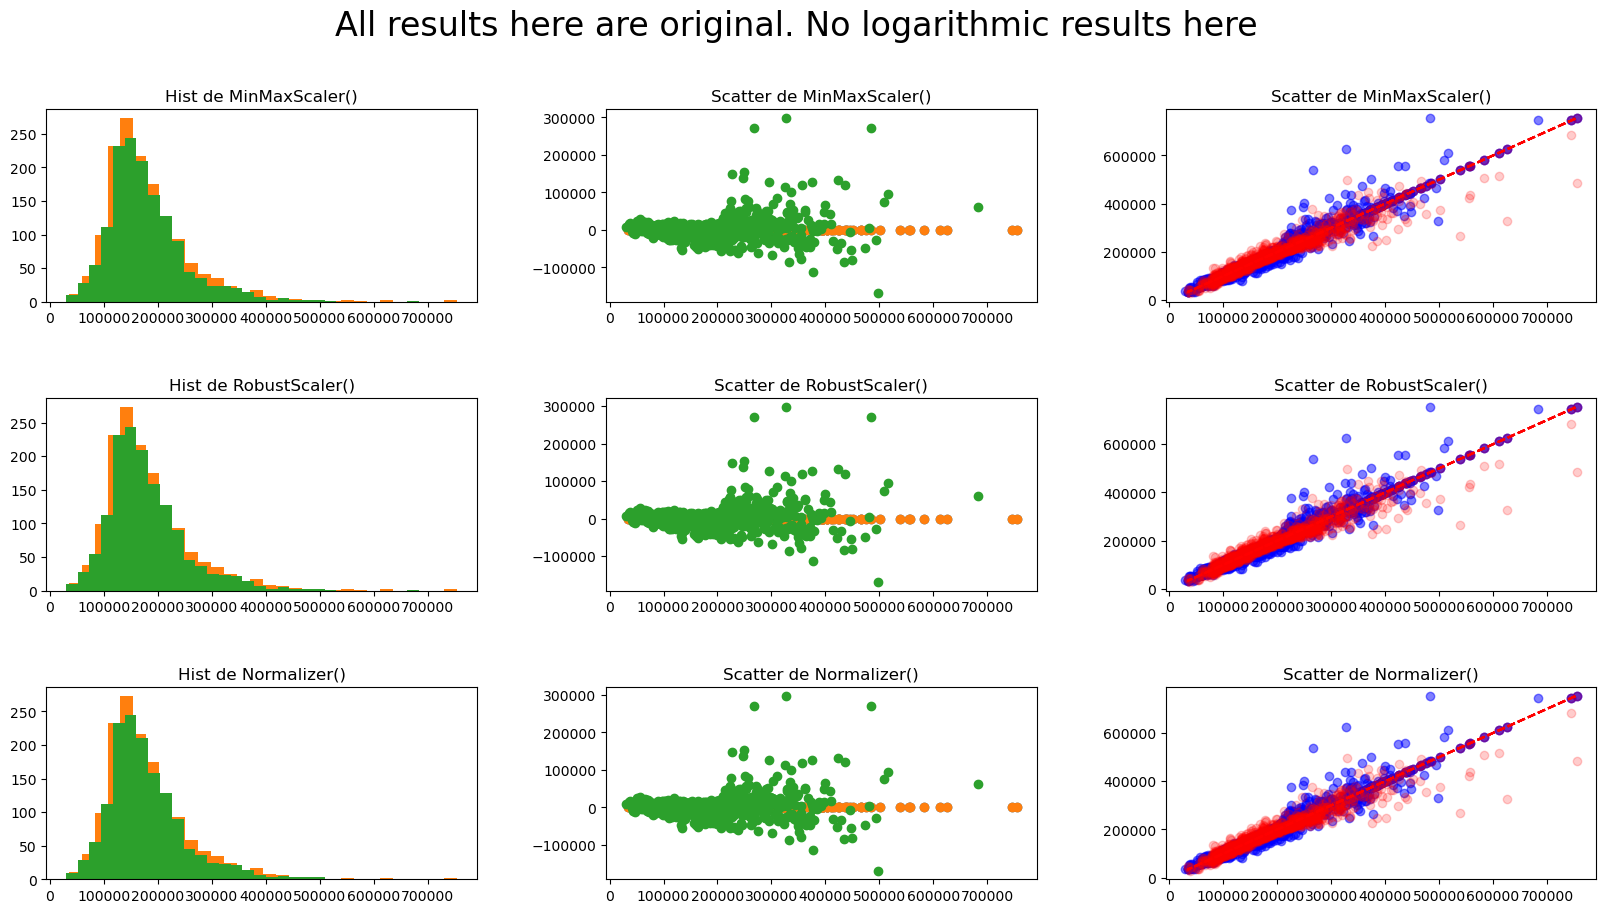

In [349]:
fig, axi = plt.subplots(3,3,figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
modlist= [mmmodel, Rmodel, nmodel] 

for i, mod in enumerate(modlist):
    mod.fit(df_with_dummies)
    res= pd.DataFrame(mod.transform(df_with_dummies), columns= df_with_dummies.columns)
    reg_model.fit(res, y)
    yhat =reg_model.predict(res)
    rmse = root_mean_squared_error(np.exp(yhat), np.exp(y))
    r2 = r2_score(np.exp(yhat), np.exp(y))
    print('root mean squared error with', mod, ' :',  rmse)
    print('r2 with', mod, ' :', r2)
    for row, mod in enumerate(modlist):
        for col in range(3):
            if col ==0:
                axi[row,col].hist(np.exp(yhat),bins=30)
                axi[row,col].set_title(f'Hist de {mod}')
            if col ==1:
                residuals = np.exp(y)- np.exp(yhat)
                axi[row,col].scatter(np.exp(yhat) , residuals)
                axi[row,col].set_title(f'Scatter de {mod}')
            if col ==2:
                axi[row,col].scatter(np.exp(yhat) ,np.exp(y) ,color='blue', alpha=0.5)
                axi[row,col].scatter(np.exp(y) ,np.exp(yhat) ,color='red', alpha=0.2)
                axi[row,col].plot(np.exp(y),np.exp(y), color='red', linestyle='--')
                axi[row,col].set_title(f'Scatter de {mod}')
plt.suptitle('All results here are original. No logarithmic results here', fontsize=24)
plt.show()

### Finnaly let's add boxcox Transformation and see how it performs in the first 10 columns compared with the other scalers

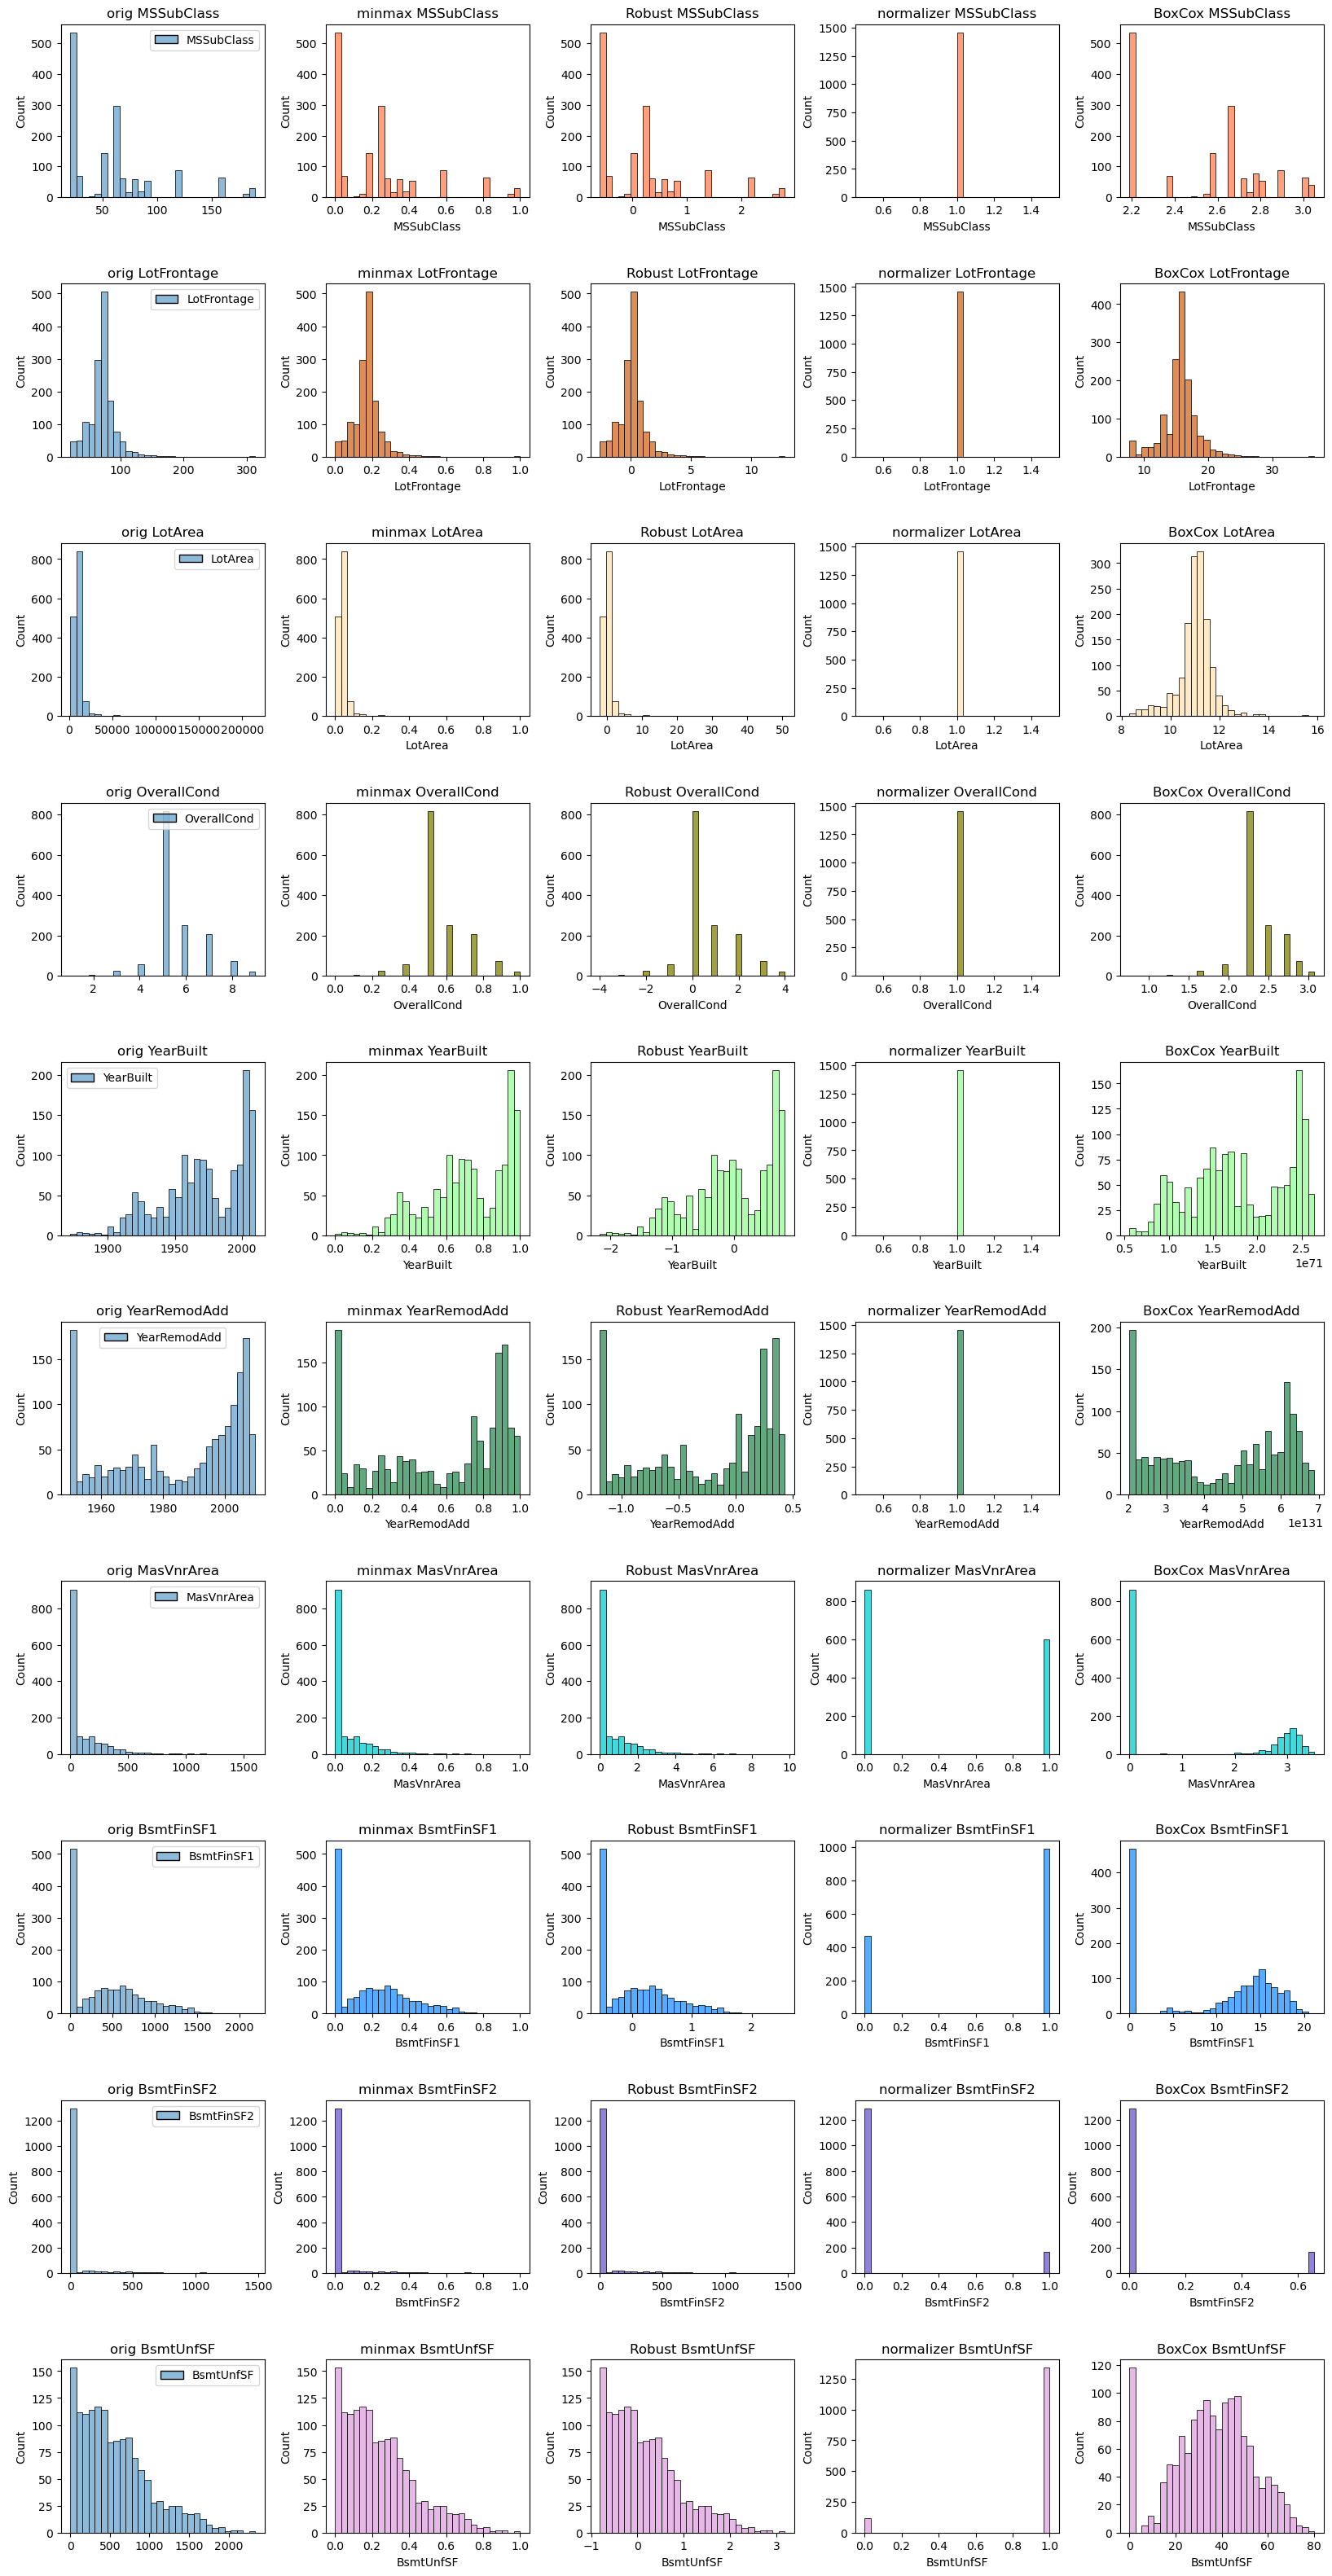

In [358]:
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import boxcox

fig, axi = plt.subplots(10,5, figsize=(20,40))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Get first columns
conti_subset = df_with_dummies.iloc[:, :10]

for i, (column_name, column_data) in enumerate(conti_subset.items()):
    # Convert to 2D
    column_data = column_data.to_frame()

    # Original Column
    sns.histplot(column_data, bins=30, ax=axi[i, 0], color=color[i])
    axi[i, 0].set_title(f'orig {column_name}')

    # MinMaxScaler
    mm_scaler = MinMaxScaler()
    mm_res = pd.DataFrame(mm_scaler.fit_transform(column_data), columns=[column_name])
    sns.histplot(mm_res[column_name], bins=30, ax=axi[i, 1], color=color[i])
    axi[i, 1].set_title(f'minmax {column_name}')

    # RobustScaler
    robust_scaler = RobustScaler()
    r_res = pd.DataFrame(robust_scaler.fit_transform(column_data), columns=[column_name])
    sns.histplot(r_res[column_name], bins=30, ax=axi[i, 2], color=color[i])
    axi[i, 2].set_title(f'Robust {column_name}')

    # Normalizer
    normalizer = Normalizer()
    n_res = pd.DataFrame(normalizer.fit_transform(column_data), columns=[column_name])
    sns.histplot(n_res[column_name], bins=30, ax=axi[i, 3], color=color[i])
    axi[i, 3].set_title(f'normalizer {column_name}')

    # Boxcox
    res, _ = boxcox(column_data.squeeze() + 1)  # Agregar 1 para evitar valores negativos
    res1 = pd.DataFrame(res, columns=[column_name])
    sns.histplot(res1[column_name], bins=30, ax=axi[i, 4], color=color[i])
    axi[i, 4].set_title(f'BoxCox {column_name}')

plt.show()

### We can confirm Standard Scaler , MinMaxScaler, RobustScaler return similar results, but CoxBox return in some vlaues big differences in the histograms. Check BsmtUntSF or BsmtFinSF1 or LotArea. The biggest diference are with Normalizer Scaler.